In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import random 
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './train.csv'#'./HPAv18RBGY_wodpl.csv'

MOREDATA = './moredata/'
MORELABELS = './rare.csv'

SAMPLE = './sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
#moredata_names = list(pd.read_csv(MORELABELS)['Id'])
train_names = sorted({f[:36] for f in os.listdir(TRAIN)})
#train_names += moredata_names
test_names = sorted({f[:36] for f in os.listdir(TEST)})
print('train:',len(train_names),'  test:',len(test_names))
#tr_n,val_n = train_test_split(train_names, test_size=0.1, random_state=seed)
#print('train:',len(tr_n),'  val:',len(val_n))

train: 31072   test: 11702


In [6]:
"""
from sklearn.model_selection import KFold

i=1
kf = KFold(n_splits=5,shuffle=True,random_state=seed)

for train, test in kf.split(train_names):
    np.save('./KF_2/train_%s.npy'% i,train)
    np.save('./KF_2/test_%s.npy'% i,test)
    print("%s %s" % (train, test))
    i+=1
"""

'\nfrom sklearn.model_selection import KFold\n\ni=1\nkf = KFold(n_splits=5,shuffle=True,random_state=seed)\n\nfor train, test in kf.split(train_names):\n    np.save(\'./KF_2/train_%s.npy\'% i,train)\n    np.save(\'./KF_2/test_%s.npy\'% i,test)\n    print("%s %s" % (train, test))\n    i+=1\n'

In [7]:
tr_n,val_n= [],[]
KF_num = 1
for i in np.load('./KF_2/train_%s.npy'%KF_num):
    tr_n.append(train_names[i])
for i in np.load('./KF_2/test_%s.npy'%KF_num):
    val_n.append(train_names[i])
print('train:',len(tr_n),'  val:',len(val_n))

train: 24857   val: 6215


In [8]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      2,2,1,1,2,1,1,1,
                      2,1,2,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
 
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,'train.csv'))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

26349


In [9]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    #try:
    #    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
    #           for color in colors]
    #except:
    #    img = [cv2.imread(os.path.join(MOREDATA, id+'_'+color+'.png'), flags).astype(np.float32)/255
    #           for color in colors]
    return np.stack(img, axis=-1)

In [10]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [11]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    #stats = A([0.07265, 0.05087, 0.0456 , 0.08611],[0.12196, 0.09341, 0.13714, 0.13533])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

# HPAv18 all RGBY (each image is colored RGB png image 512x512)
#stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])
#HPAv18+orginal
#([0.05634, 0.05198, 0.03216, 0.09692],[0.0859 , 0.08025, 0.0859 , 0.13703])

#([0.07265, 0.05087, 0.0456 , 0.08611],[0.12196, 0.09341, 0.13714, 0.13533])

In [12]:
nw = 2   #number of workers for data loader
arch = resnet18 #specify target architecture

bs = 4
sz = 256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

RuntimeError: CUDA error: out of memory

In [ ]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [ ]:
"""
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in tqdm(iter(md.trn_dl)):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std
"""

In [13]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [14]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [15]:
from newConvLearner import ConvLearner

sz = 512 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.models.model = torch.nn.DataParallel(learner.models.model,device_ids=[0, 1])
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = nn.BCEWithLogitsLoss()
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

RuntimeError: CUDA error: out of memory

In [ ]:
lr = 0.5e-2

learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [ ]:
learner.load('./res18_1/ResNet18_512_1')

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.6239902545697701                                  
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.089626   0.07735    0.972867   0.597148  
F1 macro: 0.6590326408709688                                  
    1      0.085869   0.073699   0.973384   0.634945  
F1 macro: 0.6612578426465088                                  
    2      0.082316   0.072751   0.97347    0.636117  
F1 macro: 0.6657989638088244                                  
    3      0.081423   0.07234    0.973683   0.6429    
F1 macro: 0.666082298345347                                   
    4      0.082906   0.072338   0.973275   0.645461  
F1 macro: 0.6713825974195557                                  
    5      0.081148   0.07145    0.974051   0.650746  
F1 macro: 0.6685030430372718                                  
    6      0.078176   0.070843   0.973849   0.650521  
F1 macro: 0.6722166627091825                                  
    7      0.078335   0.070802   0.97412    0.655005  


In [21]:
learner.save('./KF/KF_%s'%KF_num)

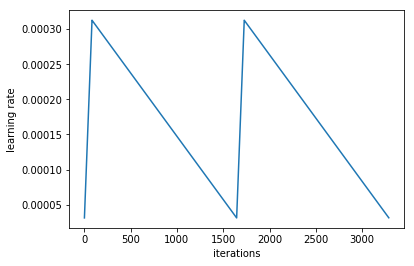

In [22]:
learner.sched.plot_lr()

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.6754610384348078                                  
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.077656   0.071457   0.973786   0.654903  
F1 macro: 0.681773248388598                                   
    1      0.077849   0.07045    0.974143   0.663328  
F1 macro: 0.6826615576105833                                  
    2      0.075978   0.070915   0.974056   0.662942  
F1 macro: 0.6759819018695372                                  
    3      0.076732   0.070319   0.974062   0.655105  
F1 macro: 0.681971601450009                                   
    4      0.077024   0.06957    0.974574   0.659956  
F1 macro: 0.676304297401983                                   
    5      0.074617   0.06985    0.974292   0.661298  
F1 macro: 0.6761363024668942                                  
    6      0.074553   0.069503   0.974309   0.660006  
F1 macro: 0.6751608951520888                                  
    7      0.074937   0.070012   0.974212   0.656956  


In [24]:
learner.save('./KF/KF_%s'%KF_num)

In [25]:
preds_t,y_t = learner.TTA(n_aug=4,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)
np.save('./KF_2/KF_%s.npy'%KF_num,pred_t)

In [16]:
#60 44 37 51 50
pre_1 = np.load('./KF_2/KF_1.npy')
pre_2 = np.load('./KF_2/KF_2.npy')
pre_3 = np.load('./KF_2/KF_3.npy')
pre_4 = np.load('./KF_2/KF_4.npy')
pre_5 = np.load('./KF_2/KF_5.npy')
#pred_t = (pre_1*60+pre_2*44+pre_3*37+pre_4*51+pre_5*50)/(sum([60,44,37,51,50]))

In [19]:
pred_t = sigmoid_np(pre_1)+sigmoid_np(pre_2)+sigmoid_np(pre_3)+sigmoid_np(pre_4)+sigmoid_np(pre_5)

In [23]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

In [17]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [24]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [-0.1594  -0.17874 -0.29031 -0.24069 -0.12672 -0.23908 -0.29989  0.00111 -0.25861  0.43281  0.39961 -0.47267
 -0.15512 -0.41161  0.02072 -0.33834 -0.4241   0.18588 -0.32208 -0.37336 -0.32684 -0.33869 -0.28217 -0.3701
  0.14796 -0.20674 -0.1839   1.40617]
F1 macro:  0.7056047755838544
F1 macro (th = 0.0):  0.6656417551788607
F1 micro:  0.7560245472234696


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)


In [25]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Thresholds:  [-0.10171 -0.12348 -0.2885  -0.29116 -0.15817 -0.25156 -0.24378 -0.08439 -0.25896  0.41512  0.3489  -0.29194
 -0.22653 -0.41917  0.14531 -0.06644 -0.42342  0.21369 -0.3292  -0.36718 -0.28692 -0.31433 -0.30114 -0.38166
  0.06506 -0.20152 -0.19993  0.06627]
F1 macro avr: 0.6779722397206621
F1 macro:  0.6982649617365662
F1 micro:  0.7544451946882736


In [26]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Fractions:  [0.38501 0.03348 0.08859 0.0461  0.05305 0.0582  0.0255  0.07134 0.00515 0.00438 0.00386 0.02627 0.05408
 0.03039 0.0291  0.00026 0.02936 0.00412 0.04687 0.03992 0.0103  0.15426 0.08035 0.07211 0.00773 0.32629
 0.01262 0.00103]
Fractions (true):  [0.37342 0.0376  0.09426 0.04739 0.05743 0.06953 0.02627 0.07649 0.00773 0.00515 0.00464 0.02936 0.06567
 0.04507 0.03554 0.00129 0.03296 0.01159 0.05048 0.04121 0.01107 0.13984 0.07906 0.07777 0.00953 0.28097
 0.01828 0.00335]


Nucleoplasm 0 0.8434634974533106 -0.10170730453031421


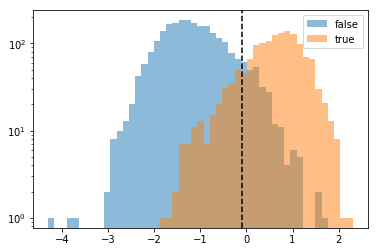

Nuclear membrane 1 0.8840579710144928 -0.12347626037718033


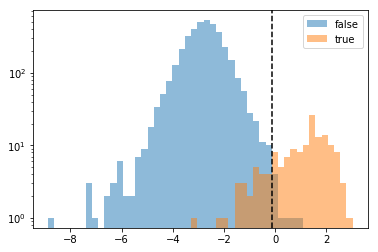

Nucleoli 2 0.7999999999999999 -0.28850459467507206


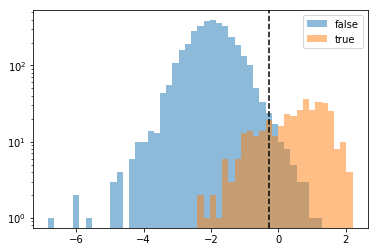

Nucleoli fibrillar center 3 0.765840220385675 -0.291158696908907


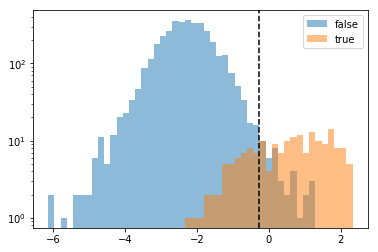

Nuclear speckles 4 0.8018648018648018 -0.15816715568378664


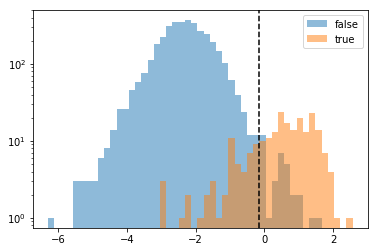

Nuclear bodies 5 0.7379032258064516 -0.2515637730722487


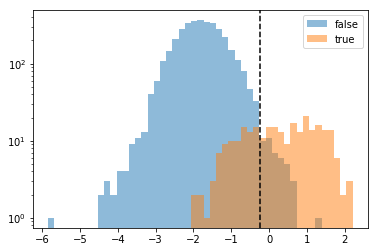

Endoplasmic reticulum 6 0.7562189054726367 -0.2437761126696781


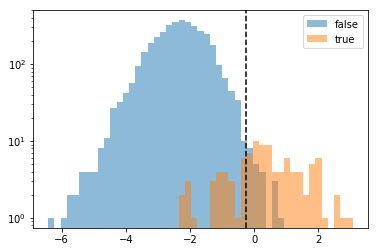

Golgi apparatus 7 0.7979094076655052 -0.08439357918568113


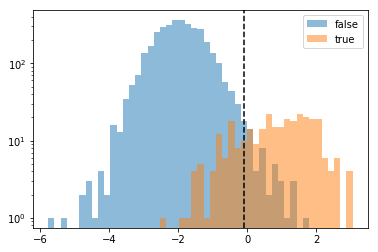

Peroxisomes 8 0.7599999999999999 -0.2589622427101036


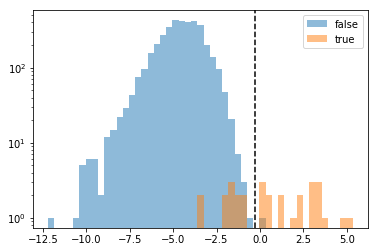

Endosomes 9 0.8648648648648648 0.4151154601443972


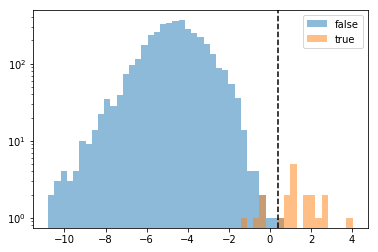

Lysosomes 10 0.8484848484848485 0.3489015280874273


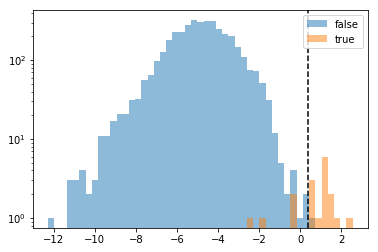

Intermediate filaments 11 0.787037037037037 -0.29194330189694606


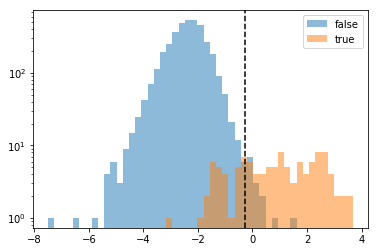

Actin filaments 12 0.7870967741935484 -0.22653150913020928


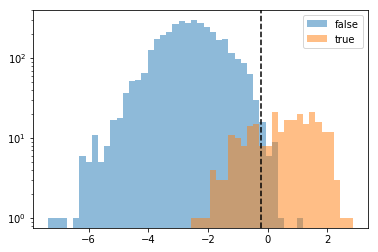

Focal adhesion sites 13 0.7098976109215018 -0.4191697364467387


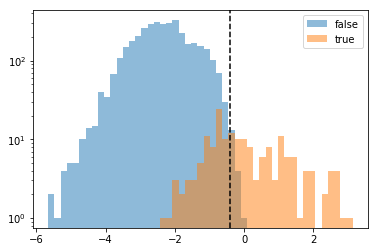

Microtubules 14 0.8207171314741034 0.1453101251925192


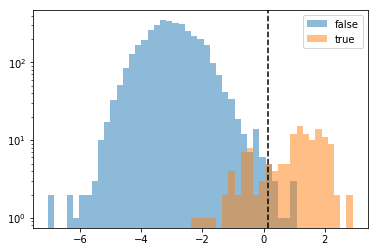

Microtubule ends 15 0.33333333333333337 -0.06643639461486882


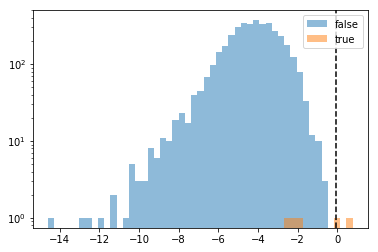

Cytokinetic bridge 16 0.5867768595041324 -0.4234154740392314


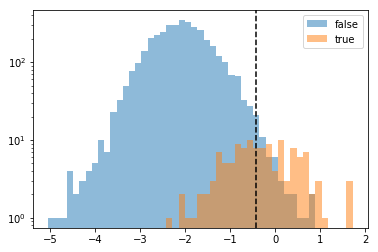

Mitotic spindle 17 0.3934426229508197 0.21369375823645004


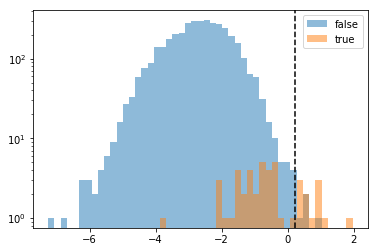

Microtubule organizing center 18 0.597883597883598 -0.3291975182576702


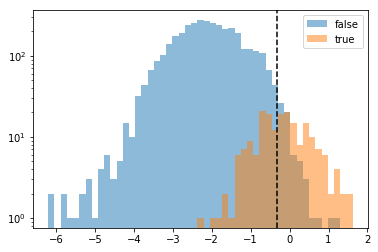

Centrosome 19 0.6222222222222223 -0.3671823274660719


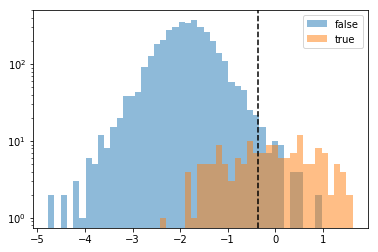

Lipid droplets 20 0.6265060240963854 -0.28691869188829056


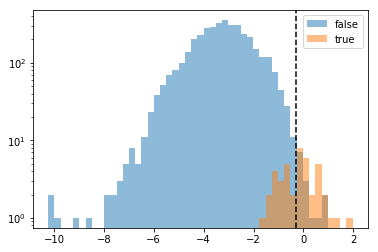

Plasma membrane 21 0.6619964973730299 -0.3143261492385417


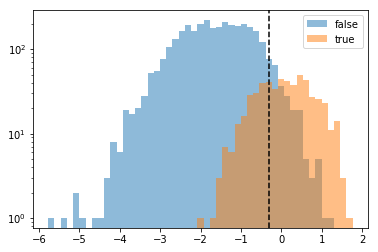

Cell junctions 22 0.6882067851373181 -0.3011424119386853


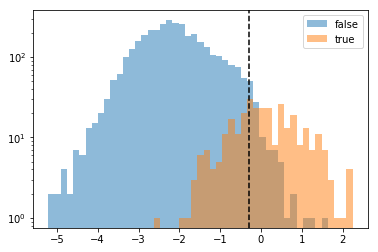

Mitochondria 23 0.8213058419243987 -0.3816578999230677


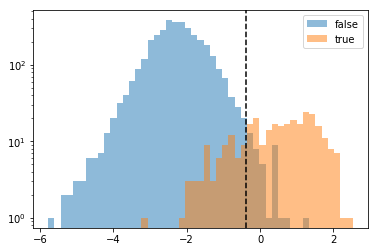

Aggresome 24 0.6865671641791045 0.06506062465704017


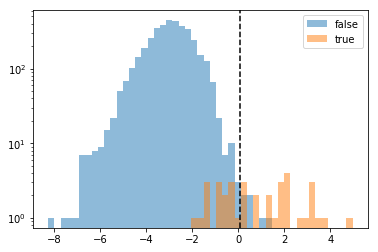

Cytosol 25 0.715860899067006 -0.20151726772094247


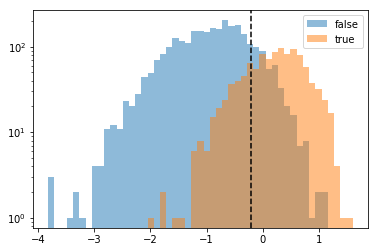

Cytoplasmic bodies 26 0.6166666666666667 -0.1999326861433058


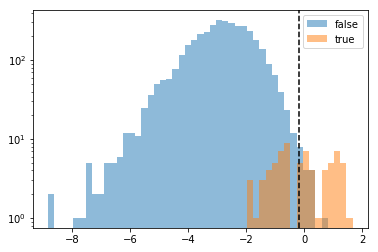

Rods & rings 27 0.23529411764705882 0.06626547427103692


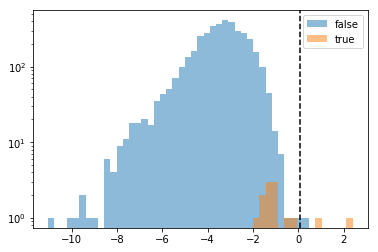

In [27]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

In [28]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [44]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        if s == '':
            s = str(list(line-th).index(max(line-th)))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':test_names,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [47]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [48]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [41]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [50]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.1055  -0.66187 -0.09219 -0.81335 -0.90208 -0.50453 -0.70707 -0.17024 -2.35166 -2.25778 -2.33092 -0.71778
 -0.96383 -0.61792 -0.33439 -1.69795 -0.67285 -0.36974 -0.39429 -0.61514 -0.67713 -0.17662 -0.64969 -0.39929
 -0.26117  0.0953  -0.91938 -1.59725]
Fractions:  [0.36242 0.04375 0.0752  0.05905 0.0746  0.0752  0.04367 0.07546 0.00983 0.00983 0.00991 0.04384 0.0441
 0.01419 0.0441  0.01    0.02846 0.01401 0.02897 0.05948 0.01    0.12622 0.02897 0.07546 0.01    0.22278
 0.02871 0.01   ]
Fractions (th = 0.0):  [0.39216 0.03102 0.07161 0.02888 0.03102 0.03897 0.01709 0.06349 0.00051 0.00085 0.00077 0.02512 0.01436
 0.00923 0.03649 0.00017 0.00615 0.00743 0.01154 0.02427 0.00367 0.09357 0.01188 0.05367 0.00872 0.26688
 0.00607 0.00017]


In [51]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [52]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [42]:
labels = pd.read_csv('train.csv').set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [45]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [2.39359 0.94769 0.84719 0.57366 0.44749 0.81232 0.79338 0.87453 0.52426 0.75174 0.77689 1.14086 1.21302
 0.59254 2.47783 0.73575 1.43297 2.75021 1.19278 1.17301 1.2983  2.15175 0.83948 1.02059 1.30436 2.33841
 1.88859 0.5822 ]
Fractions:  [0.41454 0.04033 0.11613 0.05016 0.05948 0.08084 0.03247 0.09075 0.00171 0.00145 0.00094 0.03529 0.02213
 0.01718 0.03435 0.00068 0.01718 0.00667 0.02905 0.04768 0.00547 0.12135 0.02572 0.0952  0.01034 0.2644
 0.01051 0.00034]


In [39]:
def save_pred(pred, th=0.0):
    pred_list = []
    for line in pred:
        s = (list([i for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    return pred_list

In [41]:
pred_1 = save_pred(pre_1,th_1)
pred_2 = save_pred(pre_2,th_2)
pred_3 = save_pred(pre_3,th_3)
pred_4 = save_pred(pre_4,th_4)
pred_5 = save_pred(pre_5,th_5)

In [45]:
pred_sum = []
for i in range(len(pred_1)):
    pred_sum.append(pred_1[i]+pred_2[i]+pred_3[i]+pred_4[i]+pred_5[i])
pred_sum

[[2, 2, 2, 2, 2],
 [5, 5, 5, 5, 5],
 [0, 5, 25, 0, 5, 25, 0, 5, 25, 0, 5, 25, 0, 5, 25],
 [0, 0, 0, 0, 0],
 [25, 25, 25, 25, 25],
 [4, 4, 4, 4, 4],
 [0, 4, 25, 0, 4, 25, 0, 4, 25, 0, 4, 25, 0, 4, 25],
 [0, 23, 0, 23, 0, 23, 0, 23, 0, 23],
 [0, 0, 0, 0, 0],
 [25, 25, 25, 25, 25],
 [25, 25, 25, 25, 7, 25],
 [3, 5, 3, 5, 3, 5, 3, 5, 3, 5],
 [2, 25, 2, 25, 2, 25, 2, 25, 2, 25],
 [7, 7, 7, 7, 7],
 [23, 23, 23, 23, 23],
 [4, 5, 25, 4, 5, 18, 25, 4, 5, 18, 25, 5, 25, 4, 5],
 [2, 16, 2, 14, 2, 2, 2, 14],
 [5, 5, 5, 5, 5],
 [14, 14, 21, 14, 14, 14],
 [0, 5, 0, 5, 0, 5, 0, 5, 5],
 [6, 6, 6, 6, 6],
 [2, 2, 2, 2],
 [0, 25, 0, 0, 0, 25, 0, 25],
 [0, 0, 0, 0, 0],
 [0, 4, 0, 4, 0, 4, 0, 4, 0, 4],
 [25, 25, 25, 23, 25],
 [0, 0, 0, 0, 0],
 [0, 5, 0, 5, 0, 1, 5, 0, 5, 0, 5],
 [0, 5, 25, 0, 5, 0, 5, 25, 0, 5, 0, 5, 25],
 [5, 5, 5, 0, 5, 5],
 [13, 21, 21, 13, 21, 21, 13, 21],
 [0, 7, 0, 0, 7, 0, 7, 0],
 [16, 17, 18, 16, 17, 18, 17, 18, 16, 17, 18, 16, 17, 18],
 [5, 5, 5, 5, 5],
 [0, 7, 0, 7, 0, 7, 0, 7, 0

In [55]:
class_list = [8,9,10,15,20,24,27]
pred_list = []
for i in range(len(pred_sum)):
    new = []
    for x in class_list:
        if x in pred_sum[i]:
            new.append(x)
    for x in [0,1,2,3,4,5,6,7,11,12,13,14,16,17,18,19,21,22,23,25,26]:
        if pred_sum[i].count(x)>2:
            new.append(x)
    
    if new == []:
        for x in [0,1,2,3,4,5,6,7,11,12,13,14,16,17,18,19,21,22,23,25,26]:
            if pred_sum[i].count(x)==2:
                new.append(x)

    if new == []:
        print(i,pred_sum[i])
    s = ' '.join(list([str(y) for y in new]))
    pred_list.append(s)

36 [4]
62 [25, 25]
63 [25, 25]
80 [0]
82 [0]
197 []
215 [0, 0]
216 []
222 []
258 [25, 2]
260 [21, 21]
261 [19, 19, 26]
268 [7, 7, 0, 0]
300 [22]
304 []
331 []
340 []
398 []
408 []
422 [18, 18]
442 [25]
496 [25]
510 [21, 7]
524 []
566 [21, 21, 25]
569 [23]
581 [5, 5, 23, 21]
600 [23, 23, 11]
620 []
649 []
656 [0, 0]
659 [11]
714 [25, 25]
748 [23, 23]
767 [19, 21, 19, 18, 21]
808 [0]
818 [14]
845 [26]
851 []
856 [6]
858 [21]
888 [2, 25, 25]
904 [25]
912 [0, 0]
913 []
926 [23]
939 [23, 23]
940 []
962 [23, 25]
982 [0]
990 [5, 5, 0]
1050 [25, 25]
1112 []
1186 [21, 14, 21]
1239 [0]
1247 []
1315 [23, 21]
1331 []
1335 []
1357 []
1361 []
1377 [2, 2, 25]
1402 []
1409 [11, 11]
1410 [26, 26]
1411 [23, 23]
1424 [19, 19, 25]
1436 [23]
1442 [23]
1457 [14]
1481 []
1506 []
1511 []
1534 []
1536 [7]
1572 []
1592 [5, 14, 5]
1615 [2, 25, 2, 25]
1616 [2, 2, 4]
1653 [21]
1691 [21, 18, 21]
1715 [0, 0]
1732 []
1768 [21, 23, 25, 21, 25]
1769 [22]
1787 [0]
1800 [14]
1808 [25, 23, 25, 23]
1851 [0]
1884 [6, 7, 6, 

In [56]:
df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
df.sort_values(by='Id').to_csv('protein_classification_t.csv', header=True, index=False)